In [106]:
import baostock as bs
import backtrader as bt
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tushare as ts
%matplotlib inline

In [98]:
class my_strategy1(bt.Strategy):
    #全局设定交易策略的参数
    params=(
        ('maperiod',20),
           )

    def __init__(self):
        #指定价格序列
        self.dataclose=self.datas[0].close
        # 初始化交易指令、买卖价格和手续费
        self.order = None
        self.buyprice = None
        self.buycomm = None

        #添加移动均线指标，内置了talib模块
        self.sma = bt.indicators.SimpleMovingAverage(
                      self.datas[0], period=self.params.maperiod)
    def next(self):
        if self.order: # 检查是否有指令等待执行, 
            return
        # 检查是否持仓   
        if not self.position: # 没有持仓
            #执行买入条件判断：收盘价格上涨突破20日均线
            if self.dataclose[0] > self.sma[0]:
                #执行买入
                self.order = self.buy(size=500)         
        else:
            #执行卖出条件判断：收盘价格跌破20日均线
            if self.dataclose[0] < self.sma[0]:
                #执行卖出
                self.order = self.sell(size=500)

In [87]:
def fetch_data_baostock_backtrader(stock_code, ndays = 365, fig = True):
    lg = bs.login()
    s_date = (datetime.datetime.now() - datetime.timedelta(days = 365)).strftime('%Y-%m-%d')
    e_date = datetime.datetime.now().strftime('%Y-%m-%d')
    data_list = []
    rs = bs.query_history_k_data_plus('sz.300661', "date,open,high,low,close,volume", start_date=s_date, end_date=e_date, frequency="d")
    while (rs.error_code == '0') & rs.next():
        data_list.append(rs.get_row_data())
    result = pd.DataFrame(data_list, columns=rs.fields)
    result.index=pd.to_datetime(result.date)
    result.drop('date', axis=1, inplace = True)
    result = result.astype('float')
    result['openinterest'] = 0
    bs.logout()
    if fig:
        plt.plot(result.index, result.close.astype('float'), color = 'r')
        plt.show()
    return result

In [88]:
dat = fetch_data_baostock_backtrader('300661.sh', 365,  False)

login success!
logout success!


In [89]:
dat

,open,high,low,close,volume,openinterest
date,,,,,,
2021-09-14,337.00,357.97,322.06,324.60,2755041.0,0
2021-09-15,327.00,329.00,316.00,319.00,2098621.0,0
2021-09-16,320.96,320.96,293.00,305.74,4013939.0,0
2021-09-17,306.66,317.99,301.88,313.70,1730834.0,0
2021-09-22,308.00,325.00,300.10,313.95,1589584.0,0
...,...,...,...,...,...,...
2022-09-06,154.57,155.58,151.15,152.70,1804411.0,0
2022-09-07,151.38,157.99,151.21,157.39,2158264.0,0
2022-09-08,157.39,159.66,154.30,157.31,1511693.0,0


In [99]:
#回测期间
start=(datetime.datetime.now() - datetime.timedelta(days = 365))
end=datetime.datetime.now()
# 加载数据
data = bt.feeds.PandasData(dataname=dat,fromdate=start,todate=end)

In [103]:
# 初始化cerebro回测系统设置                           
cerebro = bt.Cerebro()  
#将数据传入回测系统
cerebro.adddata(data) 
# 将交易策略加载到回测系统中
cerebro.addstrategy(my_strategy1) 
# 设置初始资本为10,000
startcash = 100000000
cerebro.broker.setcash(startcash) 
# 设置交易手续费为 0.2%
cerebro.broker.setcommission(commission=0.002) 

In [104]:
d1=start.strftime('%Y%m%d')
d2=end.strftime('%Y%m%d')
print(f'初始资金: {startcash}\n回测期间：{d1}:{d2}')
#运行回测系统
cerebro.run()
#获取回测结束后的总资金
portvalue = cerebro.broker.getvalue()
pnl = portvalue - startcash
#打印结果
print(f'总资金: {round(portvalue,2)}')
print(f'净收益: {round(pnl,2)}')

初始资金: 100000000
回测期间：20210914:20220914
总资金: 99949948.33
净收益: -50051.67


<IPython.core.display.Javascript object>


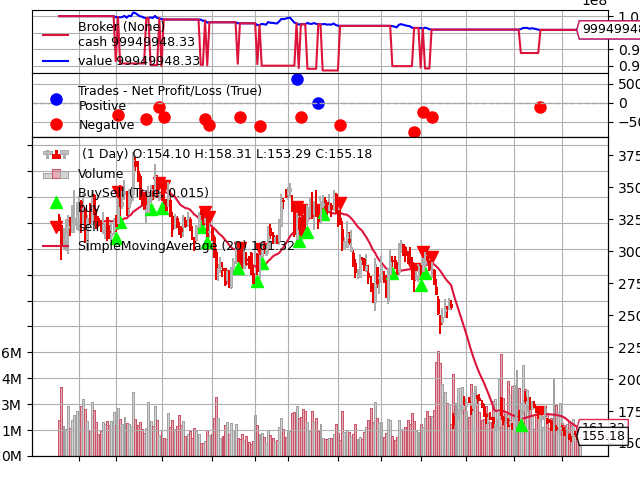

[[<Figure size 640x480 with 4 Axes>]]

In [108]:
cerebro.plot(style='candlestick')